In [1]:
import itertools
import re
import glob
import pandas
import numpy as np

MAPE = '3'
MAE = '0'
MSE = '1'
R2 = '2'


def load_group_sampling(system, folder, metric, method="mutex", min_gs=0, max_gs=1000):
    # method = "mutex"
    result_files = glob.glob(f"./result/{folder}/{system}_groupsize_*_method_{method}_*.csv")
    print(f"found {len(result_files)}")
    group_sizes_data_dict = {}
    # Add all iterations to one dataframe for each group size
    for g in [f for f in result_files if "model" not in f]:
        [group_size, iteration] = re.findall(r".*?_(\d+)", g.replace(folder, ''))
        result_data = pandas.read_csv(g)

        if group_size not in group_sizes_data_dict:
            group_sizes_data_dict[group_size] = pandas.DataFrame()
        if metric in result_data and min_gs <= int(group_size) < max_gs:
            r = result_data[metric].repeat(int(group_size))
            r.index = range(len(r))
            group_sizes_data_dict[group_size] = pandas.concat([group_sizes_data_dict[group_size], r], axis=1)

    # Average each iteration
    averaged_group_size_data = pandas.DataFrame()
    for group_size, group_size_data in group_sizes_data_dict.items():
        # print(group_size, group_size_data.columns)
        group_size_data = group_size_data.mean(1)
        group_size_data.name = int(group_size)
        averaged_group_size_data = pandas.concat([averaged_group_size_data, group_size_data], axis=1)

    averaged_group_size_data.index += 1
    averaged_group_size_data.sort_index(axis=1, inplace=True)
    averaged_group_size_data.dropna(axis=1, how='all', inplace=True)
    return averaged_group_size_data


def load(sys, folder, metric):
    data = glob.glob(f"./result/{folder}/{sys}_*.csv")
    frame = pandas.DataFrame()
    for g in data:
        [it] = re.findall(r".*?_(\d+)", g.replace(folder, ''))
        frame[it] = pandas.read_csv(g)[[metric]]
    mean = frame.mean(1)
    mean.index += 1
    return mean

Simple Graph for linear regression

In [2]:
folder = "test_case_1"

data = pandas.DataFrame()
data['Apache'] = load('apache', folder, MAPE)
data['BerkeleyDB'] = load('berkley', folder, MAPE)
data['PostgreSQL'] = load('postgre', folder, MAPE)
#data['JavaGC'] = load('javagc', '3')
data.index += 1
ax = data.plot()
ax.set_xlabel("Sample size")
ax.set_ylabel("MAPE")

KeyError: "None of [Index(['3'], dtype='object')] are in the [columns]"

Group sampling Graph - Multiple Sample sizes

found 184


Text(0.5, 1.0, 'JavaGC - Independent features')

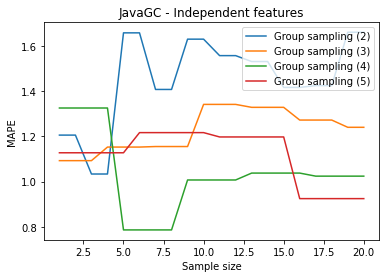

In [11]:
folder = "real_world"
folder_rs = "test_case_1"
sys = 'javagc'
#rds = load(sys + "_distance", folder_rs, MAPE)
gs = load_group_sampling(sys, folder, MAPE, 'mutex')
data = pandas.DataFrame()
for i in np.arange(2, 6, 1):
    data[f'Group sampling ({i})'] = gs[i][:20]
ax = data.plot()
ax.set_ylabel("MAPE")
ax.set_xlabel("Sample size")
ax.legend(loc="upper right")
ax.set_title('JavaGC - Independent features')

found 1160


<AxesSubplot:title={'center':'BerkeleyDB - Independent features'}, xlabel='Sample size', ylabel='MAPE'>

found 1160


<AxesSubplot:title={'center':'BerkeleyDB - Independent features'}, xlabel='Sample size', ylabel='MAPE'>

found 1160


<AxesSubplot:title={'center':'BerkeleyDB - Independent features'}, xlabel='Sample size', ylabel='MAPE'>

found 1160


<AxesSubplot:title={'center':'BerkeleyDB - Independent features'}, xlabel='Sample size', ylabel='MAPE'>

found 1160


<AxesSubplot:title={'center':'BerkeleyDB - Independent features'}, xlabel='Sample size', ylabel='MAPE'>

found 1160


<AxesSubplot:title={'center':'BerkeleyDB - Independent features'}, xlabel='Sample size', ylabel='MAPE'>

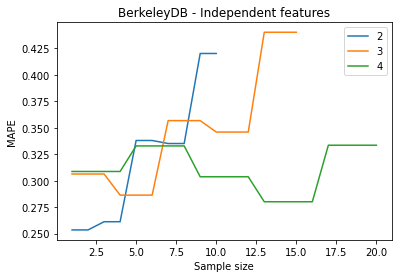

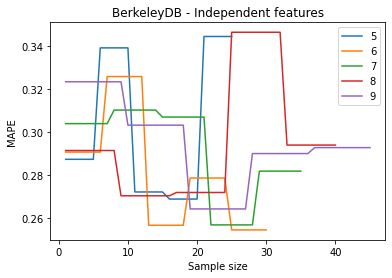

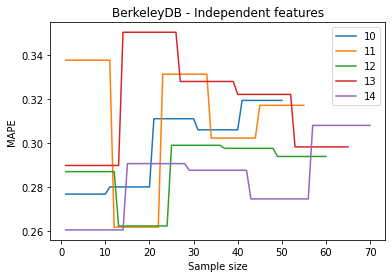

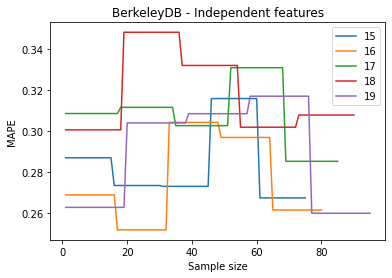

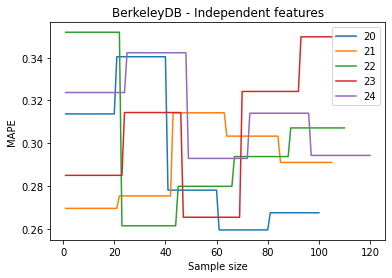

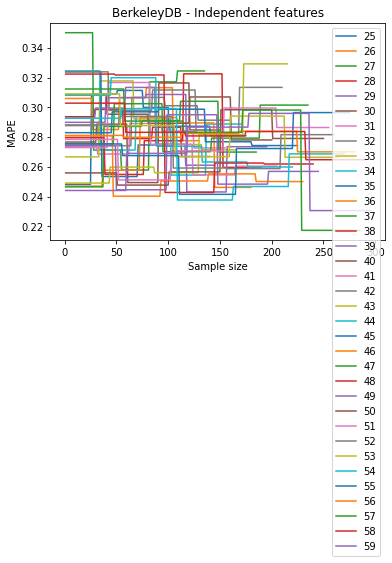

In [32]:

def create_graph(averaged_group_size_data, title):
    ax = averaged_group_size_data.plot()
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.set_xlabel("Sample size")
    ax.set_ylabel("MAPE")
    return ax


folder = "syn"
used_metric = MAPE
display(create_graph(load_group_sampling("syn-1000-pre", folder, used_metric, "mutex", 2, 5),
                     "BerkeleyDB - Independent features"));

found 20
found 20


(-140.0, 50.0)

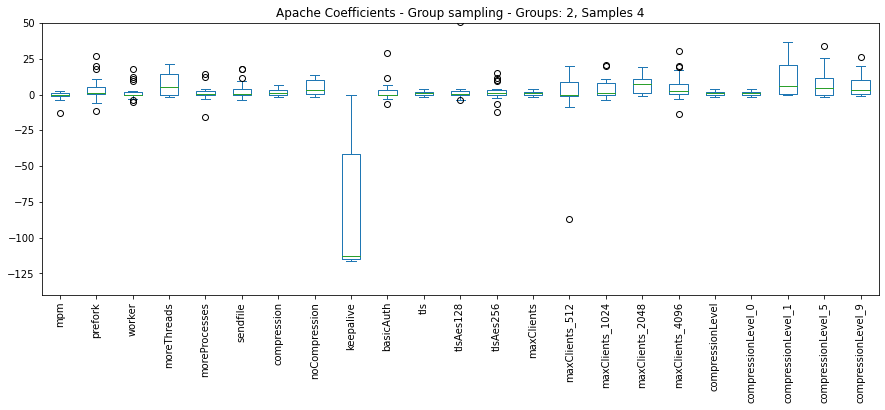

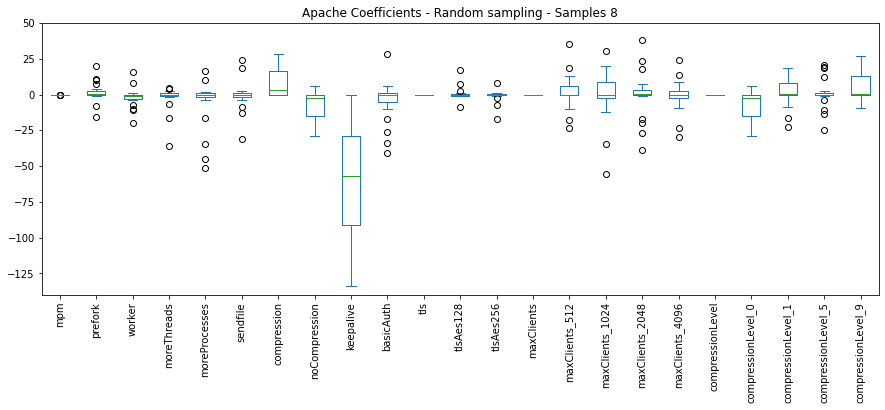

In [97]:
from matplotlib import pyplot as plt
import glob
from model.datasets import Datasets
import pandas
import re


def convert_model(file):
    csv = pandas.read_csv(file)
    df = pandas.DataFrame()
    curr = {}
    for index, row in csv.iterrows():
        if int(row[0]) in curr:
            df = df.append(curr, ignore_index=True)
            curr = {}
        else:
            curr[int(row[0])] = row['0']
    df = df.append(curr, ignore_index=True)
    df.columns = [*df.columns[:-1], 'intercept']
    return df


def load_group_sampling_model(system, folder, group_size, sample_size, method="mutex"):
    # method = "mutex"
    result_files = glob.glob(f"./result/{folder}/{system}_groupsize_{group_size}_method_{method}_*_model.csv")
    print(f"found {len(result_files)}")
    result = pandas.DataFrame()
    # Add all iterations to one dataframe for each group size
    for g in result_files:
        [group_size, iteration] = re.findall(r".*?_(\d+)", g.replace(folder, ''))
        result_data = convert_model(g)
        if result_data.shape[0] > sample_size:
            result = result.append(result_data.iloc[sample_size])
        else:
            print(group_size, iteration, sample_size)

    return result


def load_model(system, folder, sample_size, method="_distance"):
    # method = "mutex"
    result_files = glob.glob(f"./result/{folder}/{system}{method}_*_model.csv")
    print(f"found {len(result_files)}")
    result = pandas.DataFrame()
    # Add all iterations to one dataframe for each group size
    for g in result_files:
        stuff = re.findall(r".*?_(\d+)", g.replace(folder, ''))
        result_data = convert_model(g)
        if result_data.shape[0] > sample_size:
            result = result.append(result_data.iloc[sample_size])
        else:
            print(stuff, sample_size)

    return result


def create_box_plot_gs(dataset, gs, ss, with_interpect=False, folder='real_world'):
    vm, t = Datasets().get_dataset(dataset)
    df = load_group_sampling_model(dataset, folder, gs, ss)
    df.columns = [*vm.get_features(), 'Intercept']
    df = df.iloc[:, 1:]
    if not with_interpect:
        df = df.iloc[:, :-1]
    ax = df.plot.box(figsize=(15,5))
    ax.set_xticklabels(df.columns, rotation=90)
    return ax


def create_box_plot(dataset, ss, with_interpect=False, folder='test_case_1'):
    vm, t = Datasets().get_dataset(dataset)
    df = load_model(f"{dataset}", folder, ss)
    df.columns = [*vm.get_features(), 'Intercept']
    df = df.iloc[:, 1:]
    if not with_interpect:
        df = df.iloc[:, :-1]
    ax = df.plot.box(figsize=(15,5))
    ax.set_xticklabels(df.columns, rotation=90)
    return ax


sys = "apache"
ss = 4
gs = 2

create_box_plot_gs(sys, gs, ss, False, 'real_world')
plt.title(f"Apache Coefficients - Group sampling - Groups: {gs}, Samples {ss}")
plt.ylim(-140, 50)
create_box_plot(f"{sys}", gs * ss)
plt.title(f"Apache Coefficients - Random sampling - Samples {ss*gs}")
plt.ylim(-140, 50)


#load_group_sampling_model('apache', 'real_world')
#convert_model(f"./result/real_world/apache_groupsize_3_method_mutex_0_model.csv").plot.box()

In [ ]:
import itertools


def make_interactions_map(start):
    res = {}
    cnt = start + 1
    for i, j in itertools.combinations(range(1,start), 2):
        res[cnt] = (i, j)
        cnt += 1
    print(cnt)
    return res


def make_interactions_values(start, interactions):
    v = []
    idx = []
    cnt = start
    print(interactions)
    interactions = [{n[0] - 1, n[1] - 1} for n in interactions]
    print(interactions)
    for i, j in itertools.combinations(range(1,start), 2):
        if {i, j} in interactions:
            v.append(100)
            idx.append(cnt)
            print('yay')
        else:
            v.append(0)
            idx.append(cnt)
        cnt += 1
    return pandas.Series(v, index=idx)


found 22
found 20


Text(0, 0.5, 'Coefficient')

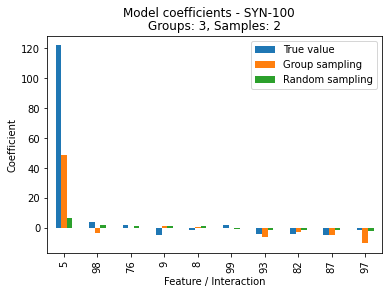

In [466]:
gs = 3
ss = 2
ds = 'syn-100-pre'
vm, t = Datasets().get_dataset(ds)
real = pandas.Series(t.weights)
#mm = make_interactions_values(len(vm.get_features()), t.interactions)
#real = real.append(mm)
real = real.append(pandas.Series([200], index=['intercept']))
a = load_group_sampling_model(ds, 'syn', gs, ss)
b = load_model('syn-100-pre', 'test_case_1', gs * ss)
df = pandas.DataFrame([
    real,
    a.mean(),
    b.mean(),
]).transpose()
df = df.iloc[:-1]
#m = make_interactions_map(len(vm.get_features()))
#df.index = [m.get(i, i) for i in df.index]
df.columns = ['True value', 'Group sampling', 'Random sampling']
df.sort_values(by=['True value'], ascending=False, inplace=True)
df.sort_values(by=['Group sampling'], ascending=False, inplace=True)
df.sort_values(by=['Random sampling'], ascending=False, inplace=True)
df = df.iloc[[0, 1, 2, 3, 4, -5, -4, -3, -2, -1]]
df.plot.bar()
plt.suptitle("Model coefficients - SYN-100")
plt.title(f"Groups: {gs}, Samples: {ss}")
plt.xlabel("Feature / Interaction")
plt.ylabel("Coefficient")

In [452]:
gs = 3
ss = 4

vm, t = Datasets().get_dataset('syn-100-pre')
real = pandas.Series(t.weights)
real = real.append(pandas.Series([200], index=['intercept']))[5]
display(real)
df = pandas.DataFrame([real])
cols = ['True value']
for gs in [2, 3, 4, 5]:
    for ss in range(1, 20 // gs):
        a = load_group_sampling_model('syn-100-pre', 'syn', gs, ss)[5]
        b = load_model('syn-100-pre', 'test_case_1', gs * ss)[5]
        df = df.append({'a': a.mean(), 'b': b.mean()}, ignore_index=True)
        cols.append(gs * ss)

display(df)

122

found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20
found 22
found 20


,0,a,b
0,122.0,NaN,NaN
1,NaN,4.387966,2.024637
2,NaN,5.118362,4.251102
3,NaN,13.742415,6.465712
4,NaN,14.915164,6.276865
5,NaN,23.529255,9.307380
6,NaN,38.371034,11.535510
7,NaN,41.050446,11.044064
8,NaN,48.305927,18.697888
9,NaN,NaN,21.504002


,a,b
2,4.387966,2.024637
3,11.674662,3.076470
4,5.118362,4.251102
5,46.288250,4.983646
6,13.742415,6.465712
8,14.915164,6.276865
9,48.370238,8.856285
10,23.529255,9.307380
12,38.371034,11.535510
14,41.050446,11.044064


,2,3,4,5,6,8,9,10,12,14,15,16,18
a,4.387966,11.674662,5.118362,46.288250,13.742415,14.915164,48.370238,23.529255,38.371034,41.050446,34.499414,48.305927,48.300000
b,2.024637,3.076470,4.251102,4.983646,6.465712,6.276865,8.856285,9.307380,11.535510,11.044064,17.644304,18.697888,21.504002


Text(0, 0.5, 'Coefficient')

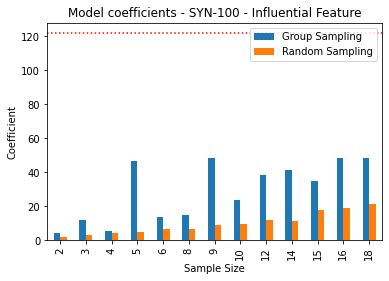

In [453]:
df2 = df.copy()

df2 = df2.iloc[1:, 1:]
df2.index = cols[1:]
df2 = df2[~df2.index.duplicated(keep='first')]
df2 = df2.sort_index()
df2.loc[18, 'a'] = 48.3
display(df2)
df2 = df2.transpose()
#df2 = df2.iloc[:-1]
display(df2)
df2 = df2.transpose()
df2.columns = ['Group Sampling', 'Random Sampling']
#df2.sort_index(inplace=True)
df2.plot.bar()
plt.axhline(y=real, color='r', linestyle='dotted')
plt.title(f"Model coefficients - SYN-100 - Influential Feature")
plt.legend(loc='upper right')
plt.xlabel("Sample Size")
plt.ylabel("Coefficient")


In [135]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

r = pandas.read_csv('./resources/PostgreSQL_pervolution_bin_measurements.csv', delimiter=";")
r = r[r['revision'] == '8.3.0']
print(r)
r.drop(['revision', 'performance', 'cpu'], axis=1, inplace=True)
X = add_constant(r)
pandas.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)

     root  fsync  synchronousCommit  fullPageWrites  trackActivities  \
0       1      0                  0               0                0   
1       1      0                  0               0                0   
2       1      0                  0               0                0   
3       1      0                  0               0                0   
4       1      0                  0               0                0   
..    ...    ...                ...             ...              ...   
859     1      1                  1               1                1   
860     1      1                  1               1                1   
861     1      1                  1               1                1   
862     1      1                  1               1                1   
863     1      1                  1               1                1   

     trackCounts  sharedBuffers_64  sharedBuffers_128  sharedBuffers_256  \
0              0                 1                  0      

/home/zwisler/Desktop/projects/bachelor/playground/group_sampling/venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


root                 0.000000e+00
fsync                9.988349e-01
synchronousCommit    9.984740e-01
fullPageWrites       9.985163e-01
trackActivities      9.985858e-01
trackCounts          9.989104e-01
sharedBuffers_64     4.127236e+04
sharedBuffers_128    1.054870e+07
sharedBuffers_256    5.222420e+05
sharedBuffers        0.000000e+00
tempBuffers_2        6.399243e+03
tempBuffers_8        1.102228e+06
tempBuffers_32       6.131288e+06
tempBuffers          0.000000e+00
workMem_256          2.061716e+05
workMem_1024         2.728371e+06
workMem_4096         2.556528e+07
workMem              0.000000e+00
dtype: float64

0.0008250935934484005
[0.5615935085631631]


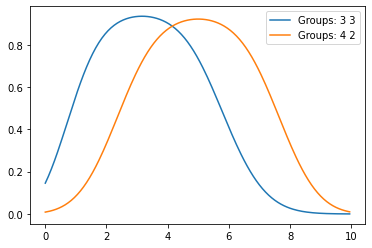

In [153]:
from scipy import interpolate
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
from scipy.interpolate import make_interp_spline, BSpline, UnivariateSpline

from statsmodels.nonparametric.smoothers_lowess import lowess


def calc(N, S, t):
    a = scipy.special.comb(N, t)
    b = ((1 / S) ** t)
    c = (1 - (1 / S)) ** (N - t)
    return a * b * c


def pprop(x, groupings, group_sizes, feature_count):
    return [1 - (1 - calc(groupings, group_sizes, t)) ** (feature_count - 1) for t in x]


def prop(x, groupings, group_sizes):
    return [calc(groupings, group_sizes, t) for t in x]


print(calc(8, 16, 4))
print(pprop([4], 8, 16, 1000))

# \binom{N}{t} \left(\frac{1}{S}\right)^{t} \left(\frac{S-1}{S}\right)^{N-t}


fig = plt.figure()
feature_count = 10
groupings = 10
t = np.arange(0, groupings, 0.05)
for groups in [3, 4]:
    plt.plot(t, pprop(
        x=t,
        groupings=groupings,
        group_sizes=feature_count // groups,
        feature_count=feature_count
    ), label=f"Groups: {groups} {(feature_count // groups)}")

#plt.plot(t, prop(t, 10, 2, 100), label=f"y{i}")
#plt.plot(t, pprop(t, 10, 2, 100), label=f"y{i}")
#plt.plot(t, prop(t, 50, 5, 100), label="y2")
#plt.plot(t, prop(t, 50, 6, 100), label="y3")
#plt.plot(t, prop(t, 50, 7, 100), label="y3")
plt.legend(loc='upper right')
# Show the pl
plt.show()

2


<AxesSubplot:>

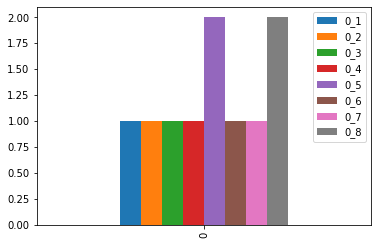

In [143]:
from numpy import sort
import random
import pandas

a = []
feature_count = 10
groupings = 10
groups = 5
print(f"{feature_count // groups}")
for j in range(groupings):
    for i in range(groups):
        a.append(random.sample(range(feature_count), feature_count // groups))

d = {}
for a in [sort(a) for a in a]:
    if a[0] != 0:
        continue
    s = f"{a[0]}_{a[1]}"
    if s in d:
        d[s] = d[s] + 1
    else:
        d[s] = 1

df = pandas.DataFrame(d, index=[0])
df.sort_index(axis=1, inplace=True)
df.plot.bar()

In [44]:
ds = 'syn-100-pre'
mean = load_group_sampling_model(ds, "syn", 3, 6).mean()
mean2 = load_model(ds, 'test_case_1',3*6).mean()
vm, t = Datasets().get_dataset(ds)
df = pandas.DataFrame()
df['real'] = t.weights
df['rsmean'] = mean2
df['mean'] = mean
df['diff'] = df['mean'] - df['real']
df['diff2'] = df['rsmean'] - df['real']

display(df.mean())
display(df)

found 22
found 20


real      0.420000
rsmean    0.324573
mean     -0.038471
diff     -0.458471
diff2    -0.095427
dtype: float64

,real,rsmean,mean,diff,diff2
0,-3,1.498801e-15,0.000000,3.000000,3.000000
1,-2,-1.708469e+00,-0.764958,1.235042,0.291531
2,0,-5.043493e-01,-3.697120,-3.697120,-0.504349
3,0,1.282793e+00,-0.583959,-0.583959,1.282793
4,-4,-1.987867e-01,-0.925000,3.075000,3.801213
...,...,...,...,...,...
95,-5,0.000000e+00,0.272957,5.272957,5.000000
96,5,8.699559e-01,2.089161,-2.910839,-4.130044
97,-1,-5.322986e-01,-4.035117,-3.035117,0.467701
98,4,1.231396e+00,-2.335530,-6.335530,-2.768604
